# Lab Week 9

## EOSC 211

### Learning Objectives:

1. Debug code

(other possibilities):

2. use dictionary keys to reference complex datasets instead of RC indexing

3. work with purely functional code?

### Intro

[link to 9 debugging commandments](https://www.tygertec.com/9-rules-debugging/)

Are we going to use a formal debugger? 

or...

Pivot learning goals and use this week to talk about dictionaries?

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# get the datafile
the_file = np.genfromtxt("lab9_old/mgsva_MJJ.csv",delimiter=",")

# extract variables from the csv
# (explicit + flat is better than implicit + nested)
lats = the_file[:,1]
lons = the_file[:,2]
u_vel = the_file[:,3]
v_vel = the_file[:,4]
#u_dev = the_file[:,5]
#v_dev = the_file[:,6]

# or
# (namespaces are a honking great idea)
var_dict = {"lats":the_file[:,1], 
            "lons":the_file[:,2], 
            "u_vel":the_file[:,3],
            "v_vel":the_file[:,4]}
            #"u_dev":the_file[:,5],
            #"v_dev":the_file[:,6]}

In [3]:
def move_to_grid(lats, lons, u_vel, v_vel):
    """
    function to create 2D arrays out of FORTRAN formatted csv data
    
    in:
    csv file with columns 15000., lon, lat, u_vel, v_vel, u_dev, v_dev
    
    (dev is the standard deviation of each velocity measurement, 15000.
    is an artifact from FORTRAN formatting)
    
    out: 
    1D arrays: lat_0, lon_0
    2D arrays: u, v
    """
    # set up grids
    # initializing with NaNs also automatically deals with points where there is
    # no data (eg. on land) because those locations will simply contain NaNs
    lon_0 = np.arange(-179,180)
    lat_0 = np.arange(-89, 89)

    u = np.full([179, 360], np.nan)
    v = np.full([179, 360], np.nan)

    # Loop through all points in .csv file.
    #
    # For each, calculate the row/col indices
    # from the lat/longs.  Lats get converted
    # into row indices 'i', and longs into column
    # indices 'j'. Since we have a 1 degree spacing
    # we just have to add the right offset
    # to make this work - for example, for latitudes
    # latitude of -89 goes to row 0,
    # latitude of -88 goes to row 1, etc.
    #
    # Then write the
    # corresponding U/V data for that lat/long
    # into the right place (i.e. index (i,j) )
    # in the U/V matrices 

    
    for k in range(len(lats)):
        i = int(lons[k]) + 78  # row index
        j = int(lats[k]) + 179  # column index
        u[i,j] = u_vel[k]
        v[i,j] = v_vel[k]
        
    return lon_0, lat_0, u, v

In [4]:
def mean2d(in_map, winlen):
    """
    Takes a 2D running mean of an input np array
    
    in:  winlen -- window length
         in_map -- numpy array on which to perform the running mean. 
        
    assumes in_map is a world map, and wraps longitude[-1] around to [0] 
    
    out: out_map -- the filtered map
    """
    # put the actual filtering operation in a subfunction
    def do_mean_dep(in_map, winlen):
        # initialize the output array and relevant variables
        out_map = np.empty_like(in_map)
        nrows, ncols = in_map.shape
        wn = int((winlen - 1) // 2)
        
        # loop through each element in the map and perform the average
        # no attempts made yet to address edge effects
        for i in range(nrows):
            for j in range(ncols):
                
                iv = i + np.arange(-wn, wn)  # indeces for rows to use
                jv = j + np.arange(-wn, wn)  # inceces for cols
                
                # don't include points above or below the map
                iv[iv < 0] = np.nan  
                iv[iv > nrows] = np.nan
                
                # wrap around points off the right edge of the map
                jv[jv > ncols] = jv[jv > ncols] - ncols
                
                # don't filter the land elements (not working.. why?)
                if np.isnan(in_map[iv,jv]):
                    out_map[iv,jv] = np.nan
                else:              
                    the_window = out_map[iv - wn:iv + wn + 1,jv - wn:jv + wn + 1]
                    # nanmean is a function that returns the mean
                    # while ignoring nan values
                    out_map[iv,jv] = np.nanmean(the_window)
        return out_map
     
    def do_mean(in_map, winlen):
        # initialize output array and internal variables
        out_map = np.empty_like(in_map)
        out_map[:] = np.nan
        nrows, ncols = in_map.shape
        wn = int((winlen - 1) // 2)
        
        # loop through every point (i, j) in the grid:
        # (ignore edges for now)
        for i in range(wn, nrows - wn):
            for j in range(wn, ncols - wn):
                # don't filter points containing nan (ie land, edge of map)
                if not np.isfinite(in_map[i,j]):
                    out_map[i,j] = np.nan
                else:
                    # create the window
                    imin = i - wn
                    imax = i + wn + 1
                    jmin = j - wn
                    jmax = j + wn + 1
                    
                    the_window = in_map[imin:imax, jmin:jmax]
                    # use nanmean to take the mean, ignoring nan values
                    out_map[i,j] = np.nanmean(the_window)
                    
        return out_map
                
    
    # check for odd winlen
    winlen = int(winlen)
    if winlen % 2 == 0:
        print("input arg 'winlen' must be even")
        return None
    # winlen of 1 means "do nothing"    
    elif winlen == 1:
        return in_map
    # do the calculation and return result
    else:
        return do_mean(in_map, winlen)

In [5]:
def mask_nth(in_map, n):
    """
    returns a 2d array with all values np.nan except points on a grid of n x n spacing
    
    in: 
        in_map: 2d numpy array
        n: desired spacing of points
        
    out:
        masked_map: 2d numpy array with mask applied
    """
    masked_map = np.empty_like(in_map)
    masked_map[:] = np.nan
    masked_map[::n,::n] = in_map[::n,::n]
    return masked_map

Equation for velocity magnitude:

$$
m = \sqrt{u^2 + v^2}
$$

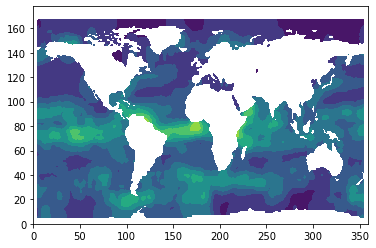

In [6]:
#lons, lats, u, v = move_to_grid(lats, lons, u_vel, v_vel)  # the standard way
lons, lats, u, v = move_to_grid(**var_dict)  # the honking great way

# calculate magnitude of current velocity
m = (u ** 2 + v ** 2) ** 0.5

# filter the velocity fields
filter_width = 11
u_filt = mean2d(u, filter_width)
v_filt = mean2d(v, filter_width)
m_filt = mean2d(m, filter_width)

# grab only the decfac^th element of each array on which to plot arrows
#arrow_mask = np.

plt.contourf(m_filt)

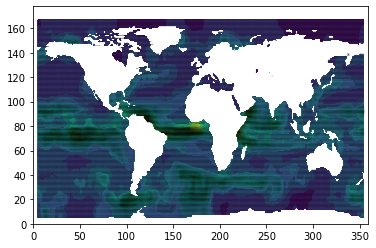

In [7]:
fig, ax = plt.subplots()

ax.contourf(m_filt)
ax.quiver(u_filt, v_filt, pivot="middle")


In [15]:
masked_map = mask_nth(m_filt, 10)

In [9]:
# splatting and doublesplatting tutorial snippet

my_list = [3,4]
my_dict = {"a":5, "b":6}

def print_vars(a, b):
    print(a)
    print(b)
    return None

print("normal function call:")
print_vars(1,2)  
print("splat from a list (or tuple)")
print_vars(*my_list)
print("double splat from a dictionary")
print_vars(**my_dict)

normal function call:
1
2
splat from a list (or tuple)
3
4
double splat from a dictionary
5
6
